In [1]:

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT

In [2]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.1, -0.29], 0.12, 0.2, 30, 60))

ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.05, -0.25], step_height=0.07, step_width=0.1, n_points=50))

left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.1, -0.25], step_height=0.07, step_width=0.1, n_points=50))

right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.0, -0.25], step_height=0.07, step_width=0.1, n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.27, 0.1, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.27, 0.1, -0.075, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.27, 0.1, 0.075, 50))

-0.14849242404917498 -0.14849242404917498 0.2757716446627535


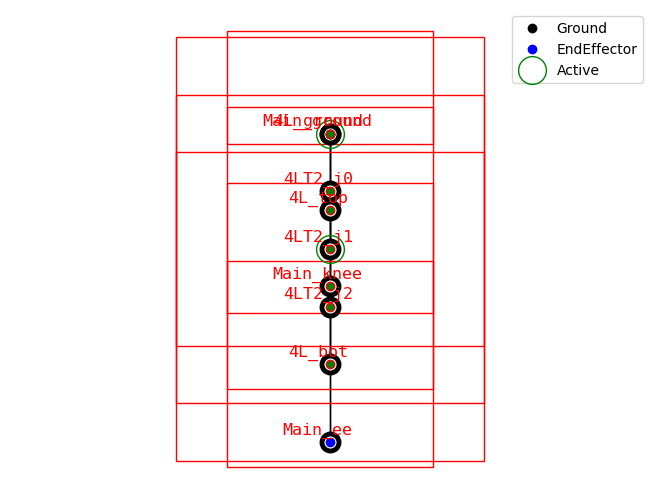

In [3]:
anlge = np.deg2rad(-45)
l1 = 0.21
l2 = 0.18

x_knee = l1 * np.sin(anlge)
y_knee = -l1 * np.cos(anlge)

y_ee = -y_knee + l2 * np.cos(anlge)
print(x_knee, y_knee, y_ee)

generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0)
graph, constrain_dict = all_graphs[3]

thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G":body_density},
                              thickness={"default": thickness, "EE":0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
)

draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

In [4]:
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass()
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)


# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [5]:
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])

reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(left_shift_step, 1)
reward_manager.add_trajectory(right_shift_step, 2)
reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_trajectory_aggregator([0,1,2], 'mean')
reward_manager.close_trajectories()

1

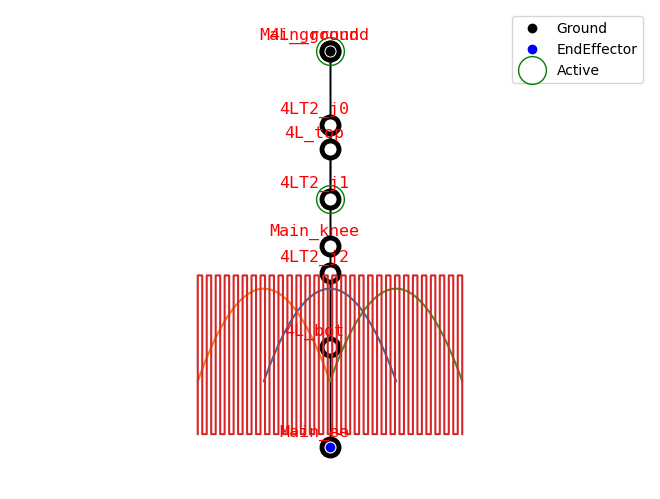

In [6]:
draw_joint_point(graph)

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [7]:
population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 5,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })

best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

acceleration_capability_weight = 1/(-best_reward.item())

Best reward in : [1.82217288]


In [8]:
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])

reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(central_vertical, 0)
reward_manager.add_trajectory(left_vertical, 1)
reward_manager.add_trajectory(right_vertical, 2)
reward_manager.add_reward(heavy_lifting, 0, 1)
reward_manager.add_reward(heavy_lifting, 1, 1)
reward_manager.add_reward(heavy_lifting, 2, 1)

reward_manager.add_trajectory_aggregator([0,1,2], 'mean')
reward_manager.close_trajectories()

1

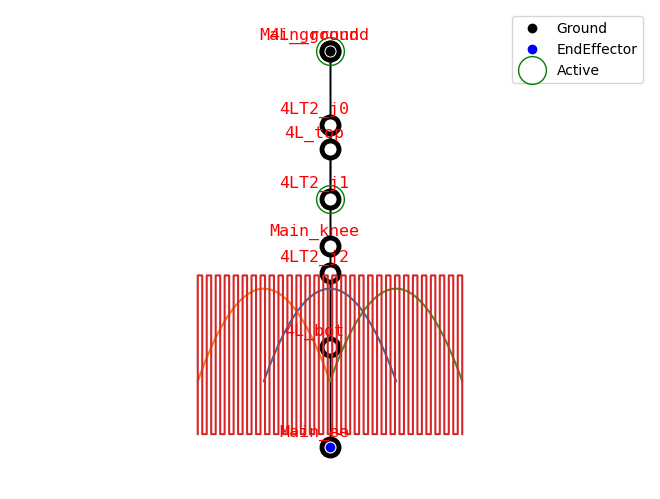

In [9]:
draw_joint_point(graph)

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [10]:
population_size = 32
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm)

res = optimizer.run(
    False, **{
        "seed": 3,
        "termination": ("n_gen", n_generations),
        "verbose": False
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

heavy_lifting_weight = 1/(-best_reward.item())

Best reward in : [3.29055491]


In [11]:


# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(left_shift_step, 1)
reward_manager.add_trajectory(right_shift_step, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, acceleration_capability_weight)
reward_manager.add_reward(acceleration_capability, 1, acceleration_capability_weight)
reward_manager.add_reward(acceleration_capability, 2, acceleration_capability_weight)


reward_manager.add_reward(heavy_lifting, 3, heavy_lifting_weight)
reward_manager.add_reward(heavy_lifting, 4, heavy_lifting_weight)
reward_manager.add_reward(heavy_lifting, 5, heavy_lifting_weight)


reward_manager.add_trajectory_aggregator([0,1,2], 'mean')
reward_manager.add_trajectory_aggregator([3,4,5], 'mean')

reward_manager.close_trajectories()

2

In [12]:
population_size = 64
n_generations = 200

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "v_acc_hl_gener_8", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed":1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       64 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -7.264763E-02 | -2.983950E+00
     2 |      128 |  0.12513 |       3 |  0.4800 |  2.00000 |  2.02165 | -2.545900E-01 | -2.983950E+00
     3 |      192 |  0.07910 |       3 |  0.4502 |  1.98942 |  2.03384 | -8.343462E-01 | -3.252994E+00
     4 |      256 | -9.1E-03 |       3 |  0.3944 |  1.97839 |  2.04906 | -1.546341E+00 | -3.583756E+00
     5 |      320 | -1.1E-02 |       3 |  0.3932 |  1.96560 |  2.06111 | -1.866618E+00 | -3.583756E+00
     6 |      384 | -9.9E-03 |       3 |  0.3939 |  1.95337 |  2.07042 | -2.022110E+00 | -3.583756E+00
     7 |      448 | -9.1E-03 |       3 |  0.3943 |  1.94322 |  2.08695 | -2.155444E+00 | -3.600459E+00
     8 |      512 |  0.00763 |       3 |  0.4048 |  1.92970 |  2.09233 | -2.269412E+00 | -3.689912E+00
     9 |      576 |  0.03140 |       3 |  0.4197 |  1.92074 |  2.10474 | 

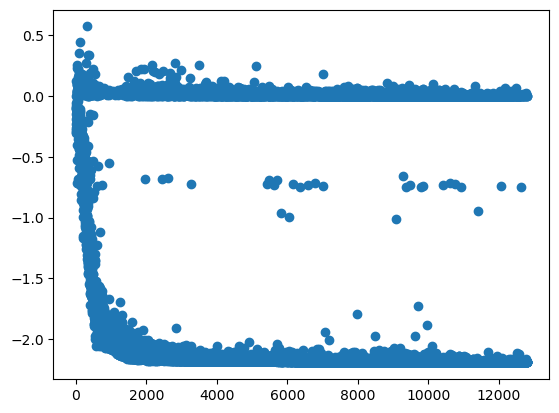

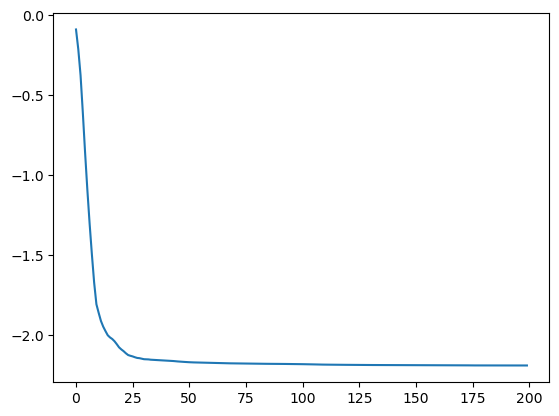

In [ ]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

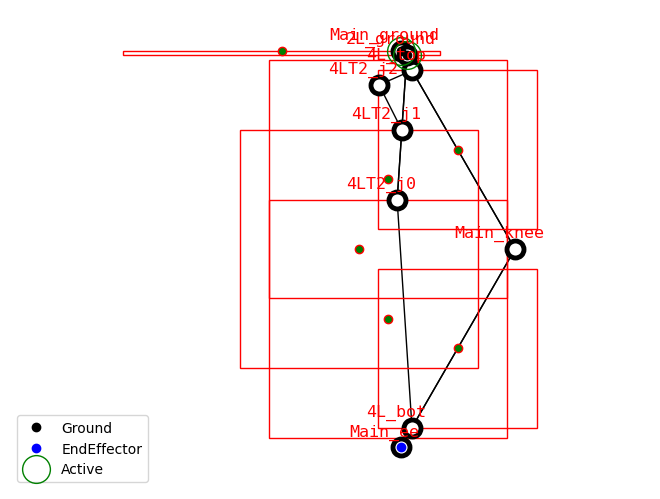

In [ ]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
visualize_constrains(problem.graph, constrain_dict)

In [ ]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 1.        , 36.20998991, 21.66488465]])

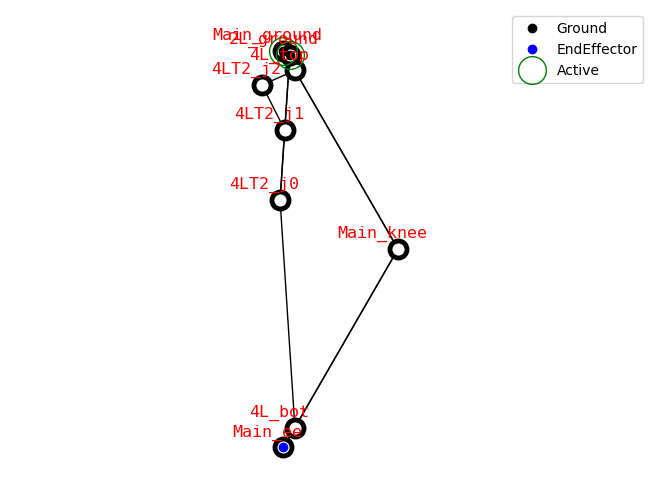

In [ ]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

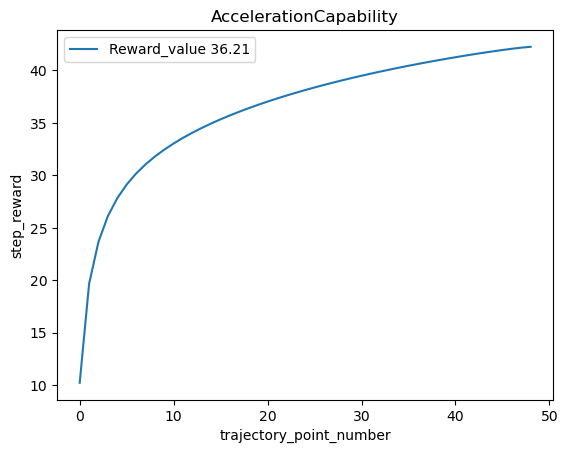

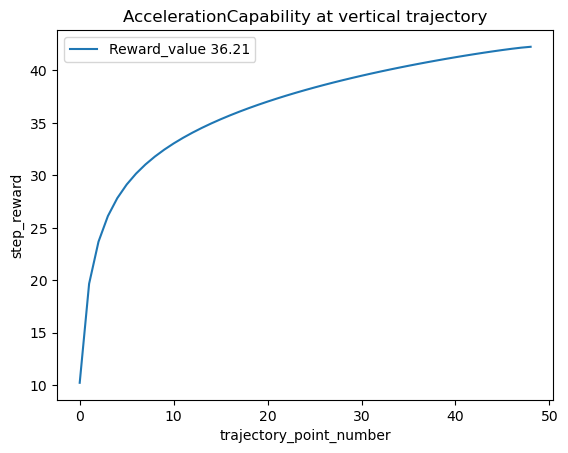

21.66488464945284


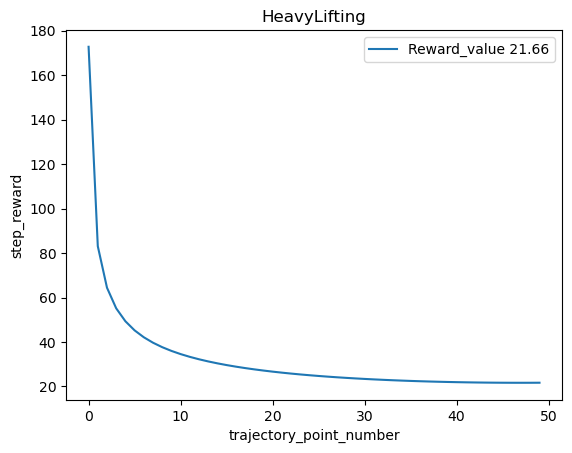

In [ ]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[1]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, central_vertical)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability at vertical trajectory')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()


fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = reward_manager.trajectories[trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, central_vertical)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
print(reward)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLifting')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()